## 1. Configuración
Crearse una cuenta en Weights and Biases (o en su board favorito) y linkear la notebook a este. Cada experimento deberá contener nombres dicientes y almacenar los (hiper)parámetros de configuración del mismo. Deberá separar los sets de datos en entrenamiento, validación y test. Utilizando solamente los sets de entrenamiento y validación, registrar la loss en train y validación en cada iteración que considere conveniente

In [ ]:
%pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu


In [ ]:
%pip install scikit-learn wandb


In [1]:
import torch
import torch.utils.data
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import wandb

import ssl
import os
from tqdm import tqdm


In [2]:
# Como contamos con procesadores ARM M1, el backend para correr con la GPU es Metal, por lo que setiamos el device a MPS
device = torch.device(
    'mps:0' if torch.backends.mps.is_available() else 'cuda:0' if torch.cuda.is_available() else 'cpu'
    )

device


device(type='mps', index=0)

In [3]:
wandb.login()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ignacio-pardo (pardo). Use `wandb login --relogin` to force relogin


True

In [4]:
ssl._create_default_https_context = ssl._create_unverified_context


In [5]:
# Chequeamos si la carpeta data existe, si no existe la creamos
download = not os.path.isdir('./data')


In [6]:
torch.manual_seed(181988)
if torch.cuda.is_available():
    torch.cuda.manual_seed(181988)


In [7]:
batch_size = 10

# Guardamos en la variable transform un tensor de 3 dimensiones (RGB) normalizado
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


### Train Set y Validation Set

In [8]:
# Descargamos el dataset CIFAR10 y lo guardamos en la variable train_set
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=download, transform=transform
)

# Guardamos en targets_ las etiquetas de las imágenes del dataset
targets_ = train_set.targets

# Dividimos el dataset en train y validation
train_idx, val_idx = train_test_split(
    np.arange(len(targets_)), test_size=0.2, stratify=targets_
)

# Creamos los samplers para train y validation
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

# Creamos los dataloaders para train y validation
train_loader = torch.utils.data.DataLoader(
    train_set, sampler=train_sampler, batch_size=batch_size, num_workers=2
)
val_loader = torch.utils.data.DataLoader(
    train_set, sampler=val_sampler, batch_size=batch_size, num_workers=2
)


### Test Set

In [9]:
# Descargamos el dataset CIFAR10 y lo guardamos en la variable test_set
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=download, transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


### Visualizacion de Imagenes

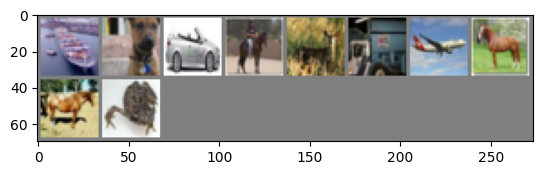

ship  dog   car   horse deer  truck plane horse horse frog 


torch.Size([3, 32, 32])

In [10]:
%matplotlib inline

# Funcion para mostrar imagenes
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Tomar imagenes random
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Mostramos imagenes
imshow(torchvision.utils.make_grid(images))

# Printeamos las etiquetas de las imagenes
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

image_size = images[0].shape
image_size


## 2. Arquitectura
Realizar experimentos variando cantidad de capas densas, nodos, hidden layers y reportar el mejor y peor experimento. ¿Qué estrategia utilizaron? ¿Qué resultados obtuvieron?

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(32 * 32 * 3, 32 * 32 * 3)
        self.fc21 = nn.Linear(32 * 32 * 3, 32 * 32)
        self.d1 = nn.Dropout(0.2)
        self.fc22 = nn.Linear(32 * 32, 800)
        self.d2 = nn.Dropout(0.2)
        self.fc23 = nn.Linear(800, 360)
        self.fc24 = nn.Linear(360, 480)
        self.fc25 = nn.Linear(480, 240)
        self.fc26 = nn.Linear(240, 120)
        self.d3 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(120, 90)
        self.fc3 = nn.Linear(90, 24)
        self.fc4 = nn.Linear(24, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc21(x))
        x = self.d1(x)
        x = F.leaky_relu(self.fc22(x))
        x = self.d2(x)
        x = F.leaky_relu(self.fc23(x))
        x = F.leaky_relu(self.fc24(x))
        x = F.leaky_relu(self.fc25(x))
        x = F.leaky_relu(self.fc26(x))
        x = self.d3(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)
        return x

experiment_name = "MPS Larger3 Softmax Dropout LeakyRelu"
net = Net()
net.to(device)


Net(
  (fc1): Linear(in_features=3072, out_features=3072, bias=True)
  (fc21): Linear(in_features=3072, out_features=1024, bias=True)
  (d1): Dropout(p=0.2, inplace=False)
  (fc22): Linear(in_features=1024, out_features=800, bias=True)
  (d2): Dropout(p=0.2, inplace=False)
  (fc23): Linear(in_features=800, out_features=360, bias=True)
  (fc24): Linear(in_features=360, out_features=480, bias=True)
  (fc25): Linear(in_features=480, out_features=240, bias=True)
  (fc26): Linear(in_features=240, out_features=120, bias=True)
  (d3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=120, out_features=90, bias=True)
  (fc3): Linear(in_features=90, out_features=24, bias=True)
  (fc4): Linear(in_features=24, out_features=10, bias=True)
)

## 3. Arquitectura CNN
Extienda el análisis utilizando capas convolucionales y reportar el mejor y peor experimento. ¿Cómo se compara?

In [12]:
class NetConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc21 = nn.Linear(120, 120)
        self.fc22 = nn.Linear(120, 120)
        self.fc23 = nn.Linear(120, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc21(x))
        x = F.leaky_relu(self.fc22(x))
        x = F.leaky_relu(self.fc23(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x


experiment_name = "MPS Conv pool(Relu) -> LeakyRelu"
net = NetConv()
net.to(device)


NetConv(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc21): Linear(in_features=120, out_features=120, bias=True)
  (fc22): Linear(in_features=120, out_features=120, bias=True)
  (fc23): Linear(in_features=120, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## 4. Funciones de activación
Realizar experimentos variando distintas funciones de activación y reportar el mejor y peor experimento. Explicar.

In [13]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()

        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(), 
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ]
        )
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        x = self.layer13(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


experiment_name = "VGG16 BatchSize 10"
net = VGG16()
net.to(device)

# Apply net.transform to all images in train_loader, test_loader, val_loader

train_loader.dataset.transform = net.transform
test_loader.dataset.transform = net.transform
val_loader.dataset.transform = net.transform


## 5. Optimizadores
Realizar experimentos evaluando distintos optimizadores, schedulers y reportar el mejor y peor experimento. ¿Qué estrategia utilizaron? ¿Qué resultados obtuvieron?

In [14]:
## Parámetros de entrenamiento
learning_rate = 0.02
momentum = 0.9
epochs = 10

project_name = "TP3"

# Optimizador y función de pérdida
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    net.parameters(),
    lr=learning_rate,
    momentum=momentum
)


## 6. Entrenamiento
Realizar experimentos evaluando distintos batch-sizes, epochs y reportar el mejor y peor experimento. ¿Qué resultados obtuvieron?

### Entrenamos

In [27]:
experiment_name = "VGG16 BatchSize 10"


In [15]:
wandb.init(
    # seteamos el projecto donde se va a guardar el experimento en wandb
    project=project_name,
    name=experiment_name,
    
    # trackeamos los hiperparámetros y las métricas
    config={
        "learning_rate": learning_rate,
        "momentum": momentum,
        "batch_size": batch_size,
        "epochs": epochs,
    },
)


In [16]:
try:
    iterator = tqdm(
        range(epochs),
        total=epochs,
        desc="Epoch"
    )

    for epoch in iterator:
        
        # ---------------- SECCION DE TRAIN -----------------

        running_loss = 0.0
        train_correct = 0
        total = 0

        for i, data in enumerate(train_loader, 0):

            # Los datos son una lista de [inputs, labels]
            # inputs, labels = data
            inputs, labels = data[0].to(device), data[1].to(device)

            # Reiniciamos gradientes
            optimizer.zero_grad()

            # forward + backward + optimize

            outputs = net(inputs) # forward
            loss = criterion(outputs, labels) # perdida
            loss.backward() # backward
            optimizer.step() # optimizacion

            # print statistics
            running_loss += loss.item()
            # if i % 200 == 199:  # print every 200 mini-batches
            #    print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        
        # ---------------- SECCION DE VALIDACION ----------------
        
        train_accuracy = 100 * train_correct / total
        running_loss = running_loss / total

        val_correct = 0
        total = 0
        val_loss = 0
        
        # Esta parte es sólo validación, no requiere entrenar, por lo que no calculamos gradientes.
        with torch.no_grad():
            for data in val_loader:
                images, labels = data[0].to(device), data[1].to(device)
                
                # Calculamos las salidas de la red para las imágenes de validación
                outputs = net(images)
                
                # La clase con mayor valor de salida es la predicción de la red
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()

        # Fin de la validación

        val_accuracy = 100 * val_correct / total
        val_loss = val_loss / total

        wandb.log(
            {
                "train_accuracy": train_accuracy,
                "val_accuracy": val_accuracy,
                "train_loss": running_loss,
                "val_loss": val_loss,
            }
        )

        iterator.set_postfix(
            {
                "train_accuracy": train_accuracy,
                "val_accuracy": val_accuracy,
                "train_loss": running_loss,
                "val_loss": val_loss,
            }
        )

    print("Finished Training")
except Exception as e:
    print(e)
finally:
    wandb.finish()


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 100%|██████████| 10/10 [10:11:08<00:00, 3666.81s/it, train_accuracy=70.6, val_accuracy=67.6, train_loss=0.0879, val_loss=0.0996]

Finished Training


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train_accuracy,▁▃▄▅▆▇▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▃▄▆▇▇▇███
val_loss,█▆▅▃▂▂▃▁▁▁
train_accuracy,70.6075
train_loss,0.08794
val_accuracy,67.63
val_loss,0.0996


In [26]:
wandb.finish()


wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


Ejemplo de guardar el modelo. Sin embargo lo deberiamos guardar para el que mejor dio en validation.

In [17]:
PATH = './cifar_vgg_16_net.pth'
torch.save(net.state_dict(), PATH)


## 7. Regularización
Evaluar alguna(s) técnica(s) de regularización. ¿Qué resultados obtuvieron?

## 8. Evaluación final
Evaluar el mejor modelo, es decir, el mejor de los ejercicios anteriores, con el set de test.

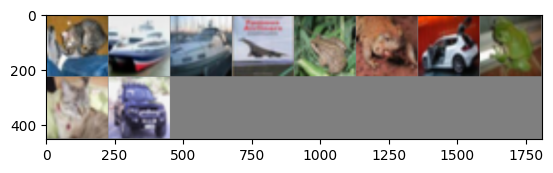

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car  
Predicted:  dog   ship  ship  ship 
Accuracy of the network on the 10000 test test_images: 67 %
Accuracy for class: plane is 73.5 %
Accuracy for class: car   is 88.1 %
Accuracy for class: bird  is 42.3 %
Accuracy for class: cat   is 56.7 %
Accuracy for class: deer  is 65.6 %
Accuracy for class: dog   is 49.7 %
Accuracy for class: frog  is 80.2 %
Accuracy for class: horse is 78.8 %
Accuracy for class: ship  is 83.2 %
Accuracy for class: truck is 65.3 %


In [23]:
#net = Net()
#net.load_state_dict(torch.load(PATH))

dataiter = iter(test_loader)
data = next(dataiter)
test_images, test_labels = data

# print test_images
imshow(torchvision.utils.make_grid(test_images))
print("GroundTruth: ", " ".join(f"{classes[test_labels[j]]:5s}" for j in range(batch_size)))

test_images, test_labels = data[0].to(device), data[1].to(device)
outputs = net(test_images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        test_images, test_labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running test_images through the network
        outputs = net(test_images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()

print(f"Accuracy of the network on the 10000 test test_images: {100 * correct // total} %")

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        test_images, test_labels = data[0].to(device), data[1].to(device)
        outputs = net(test_images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(test_labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")
